# How many subscribers should I expect?...
## Predicting new subscriptions with Machine Learning

*In this article we learn how to build a simple time series model in Python to predict the number of new newsletter subscribers in ````Mailchimp````. We then demonstrate how this process can be greatly simplified with <font color =#6b1880>[Magicsheets](ewww.magicsheets.io)</font>.*

*NOTE: You can directly implement the code in this notebook yourself: just go to the **link below***

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/magicsheets/content-marketing/blob/main/Mailchimp%20demo/article.ipynb)

*NOTE: This notebook can be used directly with your own Mailchimp dataset. Just save it down on your laptop together with your own dataset called "data.csv", and run the code again.*

Regardless of whether you

* are a subscription-based business,
* manage a ````Slack```` channel,
* manage your start-ups newsletter,
* etc.

your key metric to think about is new subscriber numbers.

For a **community manager**, knowing how big the new user traffic in the coming days is likely ot be is key for effective management of resources and efficient use of your time.

Getting your data into nice charts for analysis is one thing, but how do we **predict** the new subscriber number?

One way is to use a *time series* model.

> Our model will learn to spot a pattern in the number of daily signups and extend this pattern by the extra prediction period of 7 days 

Let's look at an example to understand what this means.
<!-- One simple and often effective way to do so is simple *regression models*.
What are these? Regression models are just fitting a line to your data.
If on x-axis (horizontal) we put the subscription times and y-axis (vertical) we plot subscription numbers, we might end up with a plot like this: -->

## The Mailchimp subscriber forecasting problem

We will try to answer the question:
> **How many new newsletter subscribers can I expect to get in the next week?**

We will do so by applying Machine Learning to find a pattern in our ````Mailchimp```` subscriber dataset and extend this pattern to formulate a prediction.

## The dataset
First, let's get the past subscriber dataset for the past 3 months 
from our ````Mailchimp````. 

*(You can read about exporting your contacts [here](https://mailchimp.com/help/view-export-contacts/) (once you log into Mailchimp, go to Audiences $\rightarrow$ select your audience $\rightarrow$ view contacts $\rightarrow$ export $\rightarrow$ select export to .csv))*

Export your Mailchimp dataset and save it in the same folder as this Jupyter notebook. In this tutorial, we are a "fake" (randomly generated) [Magicsheets.io](www.magicsheets.io) ````Mailchimp```` newsletter subscriber dataset.

Once we have the dataset saved down in the same folder, we load it using the ````Pandas```` package. (The email addresses here are randomly generated.)

In [119]:
# get pandas
import pandas as pd

# load the dataset as "data"
# NOTE: if you wish to run this code with your own data, you can either
## (1) save down your data file to the same folder as this notebook, then replace the "url" below with your file name, or
## (2) 
url = 'https://raw.githubusercontent.com/magicsheets/content-marketing/main/Mailchimp%20demo/data.csv'
data = pd.read_csv('data.csv')

# view the top 10 rows of the dataset 
data.head()

,Email Address,MEMBER_RATING,OPTIN_TIME,CONFIRM_TIME,GMTOFF,DSTOFF,TIMEZONE,CC,LAST_CHANGED
0,dnote0@360.cn,2.0,2021/10/20 13:13,2021/10/20 13:13,NaN,NaN,NaN,NaN,2021/10/14 11:21
1,bmitcheson1@google.cn,4.0,2021/9/3 17:58,2021/9/3 17:58,1.0,2.0,europe/berlin,DE,2021/9/26 12:47
2,vmaps2@t-online.de,2.0,2021/7/31 9:58,2021/7/31 9:58,1.0,2.0,Europe/Brussels,BE,2021/9/26 12:53
3,mjoscelyne3@reddit.com,2.0,2021/8/28 17:44,2021/8/28 17:44,NaN,NaN,NaN,NaN,2021/9/26 12:47
4,slurcock4@ucla.edu,2.0,2021/8/17 13:33,2021/8/17 13:33,NaN,NaN,NaN,NaN,2021/9/26 12:47


### Cleaning the data

````Mailchimp```` provides us with tonnes of useful information, such as he IP address of the subscirber, the location (actual geographical location!) of the IP address, the subscriber's time zone, etc.

For us, however, the only useful piece of information for now will be the time when the person actually became a subscriber.

> The key column for us is thu "CONFIRM_TIME" column which tells us when the subscriber became a subscriber.

In [110]:
# define "times" variable to hold the desired data input
times = data['CONFIRM_TIME']

# modify "times" to only contain the date (we don't care about the exact hour when the person subscribed; just the date is enough)
times = pd.to_datetime(times)

Once we isolated the desired "times" dataset, we want to group the subscription numbers by date.

That is, we want to know how many new subscribers there were on each day.

In [111]:
times_day_count = times.groupby(times.dt.floor('d')).size().reset_index(name='count')
print(times_day_count)

   CONFIRM_TIME  count
0    2021-07-26     46
1    2021-07-27     59
2    2021-07-28     50
3    2021-07-29     57
4    2021-07-30     62
..          ...    ...
87   2021-10-21     55
88   2021-10-22     56
89   2021-10-23     44
90   2021-10-24     56
91   2021-10-25     65

[92 rows x 2 columns]


### Visualizing the dataset

Let's plot the new subscriber counts as a function of time. We will use the famous ````matplotlib```` library for it.

Text(0.5, 1.0, 'Mailchimp new subscribers over the past 3 months')

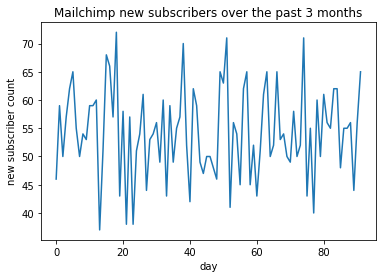

In [112]:
# get the plotting library
from matplotlib import pyplot as plt

# horizontal axis: dates
x = range(len(times_day_count['count']))

# vertical axis: counts of new subscribers 
y = times_day_count['count']

plt.plot(x,y)
plt.xlabel('day')
plt.ylabel('new subscriber count')
plt.title('Mailchimp new subscribers over the past 3 months')

This looks... messy, but some simple periodic patterns can be spotted even with "naked eye".

Hopefully Machine Learning can help us make sense of these patterns and actually predict the number of subscribers we should expect over coming days.

### Splitting the dataset

Regardless of what model we train in the end, we need to be able to assess **how good** it is.

> A reliable way to do this is to train your model only on *some* available data, and then evaluate it on the rest.

This way,
* the model first trains on *most* of the information, for example 70% of the dataset
* you then ask the model: what do you predict for the remaining 30% of the dataset?
* this prediction you can now compare with the real data that you kept hidden away from the model at training.

> For example, if you have 100 days' worth of data, you can train the model on the first 70 days. You then look at what this model predicts for the remaining 30 days, and compare this prediction with the actual, true subscriber data for this period.

Let's split the dataset. We can use a simple, predefined function, imported from the ````sktime```` library like so:

In [113]:
from sktime.forecasting.model_selection import temporal_train_test_split
data_train, data_test = temporal_train_test_split(times_day_count['count'])

In [114]:
len(data_train)

69

## The predictive model: first attempt
We now build the time series model. This can also be loaded directly from ````sktime```` library.

> The model we are going to use is called Exponential Smoothing. You can read more about the theory behind it [here](https://en.wikipedia.org/wiki/Exponential_smoothing).

In [115]:
# download the pre-defined model framework from the sktime library
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# construct the model for this case
model = ExponentialSmoothing()

### Training the model

> We train our model using the time series dataset, by directly applying the *fit* function, and feeding the *count* column of the ````times_day_count```` variable to the model

In [116]:
model.fit(data_train)

ExponentialSmoothing()

### Testing the model

We will now generate predictions for the period that the model was *not* trained on.

This would be the remaining days corresponding to the data points in ````data_test````.

We first need to tell Python that the remaining data points belong to the **Forecasting Horizon** which is a fancy name for the prediction period.

In [117]:
# Get the automatic Forecasting Horizon function
from sktime.forecasting.base import ForecastingHorizon

# define the Forecasting Horizon to be the part of the dataset that the model was not trained on (AKA the test dataset)
for_hor = ForecastingHorizon(data_test.index, is_relative=False)

# predict for the forecasting horizon
pred_test = model.predict(for_hor)

#### Assessing how good the model is

We now need some way of telling "how far" the values the model predicts for the prediction period are from the real number of new subscribers on those dates.

Let's first compare these two visually, by plotting them on the same graph.

Text(0.5, 1.0, 'New Mailchimp subscriber model: predictions vs. reality')

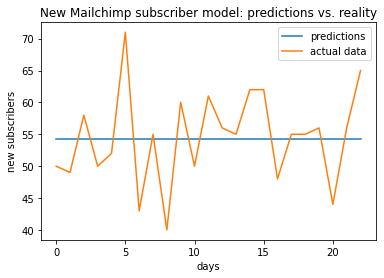

In [29]:
# horizontal axis: days of the forecasting horizon period
x = range(len(pred_test))

# vertical axis (curve 1): predicted values for the number of new subscribers
y1 = pred_test

# vertical axis (curve 1): actual values for the number of new subscribers
y2 = data_test

# now let's plot both
plt.plot(x,y1,label='predictions')
plt.plot(x,y2,label='actual data')
plt.legend()
plt.xlabel('days')
plt.ylabel('new subscribers')
plt.title('New Mailchimp subscriber model: predictions vs. reality')

If you are using the default dataset we provided here, you should be seeing a... straight line.

This might seem not extremely helpful, but we can note that the mean of the data set in the forecasting period is actually exactly equal to this value.

In [30]:
import numpy as np
np.mean(data_test)

54.47826086956522

The model **as is** not extremely helpful.

Let's quantify how "bad" this model is so we can compare with other models soon.

> A useful metric to quantify how good our predictions is called MSE (mean squared error). MSE can be high or low for good and bad models, but as a rule of thumb the lower it is, the better.

You can read more about MSE [here](https://en.wikipedia.org/wiki/Mean_squared_error).

In [31]:
# get the MSE function from the sktime library
from sktime.performance_metrics.forecasting import mean_squared_error

# calculate the error value
error1 = mean_squared_error(pred_test,data_test)
print(error1)

51.323250355315075


## Improving the predictive model

Before you throw your model (*Exponential Smoothing* model, in our case) out of the window, one way to make it work better and product more reliable predictions is to adjust the model's *hyperparameters*.

> You can think of the model as a *general framework*, and the hyperparameters as defining the actual shape of the model. For example, a "parabola model" is any function in the form $y=ax^2+bx+c$. Different values of hyperparameters $a, b, c$ will give you different shapes of the parabolic family.

In practice, we might have to spend considerable amount of time picking these and experimenting with different setups, and this process can be indeed daunting (that's why data scientists are so well paid!).

### Teaching your model periodicity

Certain things happen periodically. We might for example know that new subscribers are more likely to sign up for our newsletter on Mondays, Tuesdays and Wednesdays, and much less likely to join e.g. on weekends.

We can communicate this to our model to incorporate this periodicity by specifying the appropriate hyperparamter, like so:

In [15]:
# weekly periodicity means we expect a pattern on scale of 7 days to emerge:
periodicity = 7

# we add the appripriate hyperparameter to the model to incorporate periodicity:
model_2 = ExponentialSmoothing(sp = periodicity, seasonal='add')

> There are many more hyperparameters that you can specify and use to boost your model for better predictions. You can view the full list [here](https://www.sktime.org/en/v0.4.3/modules/auto_generated/sktime.forecasting.exp_smoothing.ExponentialSmoothing.html).

Let's see how this new, improved model does when we train it:

Text(0.5, 1.0, 'New Mailchimp subscriber model: predictions vs. reality')

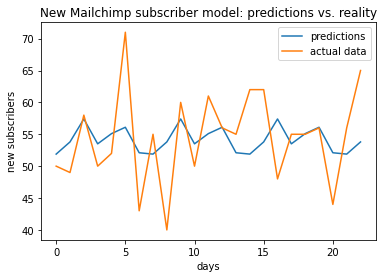

In [16]:
# train (fit) the model on the train dataset:
model_2.fit(data_train)

# product predictions for the test dataset:
pred_2 = model_2.predict(for_hor)

# plot the predictions for this new model together with the actual test dataset:
plt.plot(x,pred_2,label='predictions')
plt.plot(x,y2,label='actual data')
plt.legend()
plt.xlabel('days')
plt.ylabel('new subscribers')
plt.title('New Mailchimp subscriber model: predictions vs. reality')

This already seems to capture more of the variability in the dataset.

We can also compare the MSE (error value) for ````model_2```` and the previous ````model```` that did not look at periodicity at all:

In [19]:
error2 = mean_squared_error(pred_2, data_test)

print("the new model's error is = ",error2)

print("the new model's error is a ", 100*abs(error2-error1)/error1, "% improvement over the old model")

the new model's error is =  47.13314112736905
the new model's error is a  8.164154060659747 % improvement over the old model


Adding periodicity already improves the predictive power of the model!

In practice, we would have to spend much more time to understand and experiment with various hyperparameter setup combinations until we get a great model that produces even more satisfying results.

(In comparison, using [Magicsheets](www.magicsheets.io) this process would be 100% automated.)

## Predicting new Mailchimp subscriber numbers 

We can now finally move on to predicting the new Mailchimp subscriber numbers that we originally set out to do.

Here we are focusing on a 1 week prediction, but you can use any number of days you wish.

**Note:** *The farther ahead you are looking, the less accurate the predictions will be. You should also be careful when picking the size of the prediction period *relative to your dataset size*. For example, if you have a dataset encompassing 3 months, a week's worth of predictions might make sense, but making a 5-year forecast based on the same data is probably not going to be very accurate!*

In [33]:
# Define forecasting horizon to be 1 week (seven days)
forecasting_horizon = [1,2,3,4,5,6,7]

# generate new predictions using model_2 to make sure periodicity is included in our model
predictions = model_2.predict(forecasting_horizon)
print(predictions)

69    51.888901
70    53.800013
71    57.400023
72    53.500012
73    55.100009
74    56.100020
75    52.100006
dtype: float64


Becase we are dealing with integer (non-fraction) things (number of new subscribers) these numbers should be rounded to nearest integer, so that $1.96 \approx 2.0$, $1.01\approx 1.0$, etc. 

In [58]:
print(np.floor(predictions))

69    51.0
70    53.0
71    57.0
72    53.0
73    55.0
74    56.0
75    52.0
dtype: float64


In [76]:

y

array([ 0,  0,  0,  0,  0,  0,  0, 46, 59, 50, 57, 62, 65, 55, 50, 54, 53,
       59, 59, 60, 37, 51, 68, 66, 57, 72, 43, 58, 38, 57, 38, 51, 54, 61,
       44, 53, 54, 56, 49, 60, 43, 59, 49, 55, 57, 70, 52, 42, 62, 59, 49,
       47, 50, 50, 48, 46, 65, 63, 71, 41, 56, 54, 45, 62, 65, 45, 52, 43,
       51, 61, 65, 50, 52, 65, 53, 54, 50, 49, 58, 50, 52, 71, 43, 55, 40,
       60, 50, 61, 56, 55, 62, 62, 48, 55, 55, 56, 44, 56, 65])

Finally, we can plot these predictions as a forecasting extension of the dataset.

Text(0.5, 1.0, 'New Mailchimp subscriber model: predictions vs. reality')

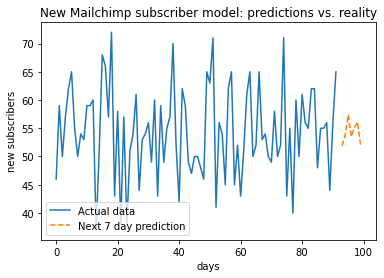

In [103]:
# add 7 days to the x-axis:
x1 = range(len(times_day_count['count']))

x2 = np.linspace(len(times_day_count['count'])+1,len(forecasting_horizon)+len(times_day_count['count']),len(forecasting_horizon))
           

# for plotting, we combine the 3 month period (historical data) and add 7 extra days (forecasting horizon) at the end with zero values
y = np.array(times_day_count['count'])

# to make predictions look different to the historical data, we plot the predictions as a curve of the same length as y, with zeros in place of historical data
z = np.array(predictions)


pred_2 = model_2.predict(for_hor)

# plot the predictions for this new model together with the actual test dataset:
plt.plot(x1,y,label='Actual data')
plt.plot(x2,z,label='Next 7 day prediction', linestyle='dashed')
plt.legend(loc='lower left')
plt.xlabel('days')
plt.ylabel('new subscribers')
plt.title('New Mailchimp subscriber model: predictions vs. reality')

## Automating the subscriber predictions with <font color=#6b1880>Magicsheets</font>

To sum up, in order to get Mailchimp new subscriber volume prediction, we had to go through the following steps:

* A. Download and prepare the dataset
1. Log into your ````Mailchimp````, find your ````Audience```` signup data and download the dataset to your computer.
2. Load the dataset into Python with ````Pandas````.
3. Identify and select the relevant data columns.

* B. Build and fine-tune the model
4. Build the *time series* model.
5. Train the model on the training set.
6. Test the model on the testing set.
7. Calculate the MSE, plot the predicitons, and adjust hyperparameters.
8. Repeat 4->7 until you are happy with your model's MSE.

* C. Make predictions
9. Make the predictions
10. The next day (or week, or month): rinse, wash, repeat!

This looks - and indeed is - daunting.

**That's why we built <font color = #6b1880>Magicsheets</font>, which simplifies this process to just 2 steps:**

1. Log into your Mailchimp and select audience for predictions
2. Re-run the model any time you want in the dedicated Slack channel with '/run-magicpipe'

> Apart from being much faster than building the model yourself, <font color = #6b1880>Magicsheets</font> also automatically selects the most suitable hyperparameter setup for your dataset, so you can have confidence in your predictions.

> You can watch a short demo of how <font color = #6b1880>Magicsheets</font> works [here](https://www.loom.com/share/4bab7f8d02fe4447b50cd3f0fb8d6c68?sharedAppSource=personal_library).

We are now working on a <font color = #6b1880>Magicsheets</font> Mailchimp pipeline that you could deploy yourself in 2-3 lines of code.


You can read more about what we are building [here](www.magicsheets.io).